In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [3]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

In [4]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [5]:
#Lines from the file of Clean lines
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
613,10425.8870
614,10426.6020
615,10535.1220
616,10580.0390


In [6]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,4060.857814,0.303661,4060.8601
1,4068.420377,0.205213,4068.4198
2,4080.988952,0.179634,4080.9899
3,4086.158769,0.218044,4086.1573
4,4088.248370,0.279245,4088.2476
...,...,...,...
613,10425.898921,0.865645,10425.8870
614,10426.603171,0.828575,10426.6020
615,10535.134792,0.693674,10535.1220
616,10580.039381,0.901596,10580.0390


### Calculate the bisector for strange lines

In [7]:
# Made a great range
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points
# 
#Made a range of 0.3mA for the wavelength
local_points_bis = width_minimums(closer_lines,raw_data,0.08)
local_points_bis

[          Wave (cm)     nFlux     rFlux       Wave A
 19717  24625.821044  0.950627  0.002286  4060.778312
 19718  24625.817277  0.961715  0.002307  4060.778933
 19719  24625.813511  0.984687  0.002333  4060.779554
 19720  24625.809744  0.991006  0.002330  4060.780175
 19721  24625.805978  0.984096  0.002292  4060.780796
 ...             ...       ...       ...          ...
 19969  24624.871877  0.820403  0.002495  4060.934834
 19970  24624.868111  0.827478  0.002471  4060.935456
 19971  24624.864344  0.832164  0.002484  4060.936077
 19972  24624.860578  0.828174  0.002526  4060.936698
 19973  24624.856811  0.832083  0.002568  4060.937319
 
 [257 rows x 4 columns],
           Wave (cm)     nFlux     rFlux       Wave A
 31870  24580.046351  0.857861  0.002252  4068.340579
 31871  24580.042584  0.865318  0.002287  4068.341202
 31872  24580.038818  0.879990  0.002308  4068.341826
 31873  24580.035051  0.888621  0.002318  4068.342449
 31874  24580.031285  0.889196  0.002338  4068.343073
 

In [58]:
bisectors = []
for j in range(0,len(local_points_bis)):
    data_bisec = local_points_bis[j]
    minimum = data_bisec[data_bisec['Wave A'] == closer_lines['min_wave'].iloc[j]].index[0]
    list_index = data_bisec.index.values
    bisec_wave = []

    left = -(min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum
    right = (min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum

    left_data = data_bisec.loc[left:minimum].reset_index(drop=True)
    right_data = data_bisec.loc[minimum:right].sort_values('Wave A', ascending=False).reset_index(drop=True)

    bisec = pd.DataFrame()
    bisec['distance'] = (right_data['Wave A'] - left_data['Wave A'])/2
    bisec['Wave c'] = left_data['Wave A'] + bisec['distance']
    bisec['c profile'] = ((bisec['Wave c']/closer_lines['Fe line'].iloc[j]) -1)*const.c 
    bisec['distance flux'] = (right_data['nFlux'] - left_data['nFlux'])/2
    bisec['c flux'] = left_data['nFlux'] + bisec['distance flux']

    bisectors.append(bisec)
    
bisectors[0]

,distance,Wave c,c profile,distance flux,c flux
0,0.078883,4060.857815,-168.670748,-0.066770,0.894945
1,0.078261,4060.857815,-168.672523,-0.076262,0.908425
2,0.077640,4060.857815,-168.673674,-0.081764,0.909242
3,0.077019,4060.857815,-168.676029,-0.081847,0.902249
4,0.076398,4060.857815,-168.677762,-0.079259,0.896791
...,...,...,...,...,...
123,0.002484,4060.857814,-168.783758,-0.000180,0.353432
124,0.001863,4060.857814,-168.783198,0.005970,0.371881
125,0.001242,4060.857814,-168.783842,0.002736,0.365622
126,0.000621,4060.857814,-168.783863,-0.002994,0.327687


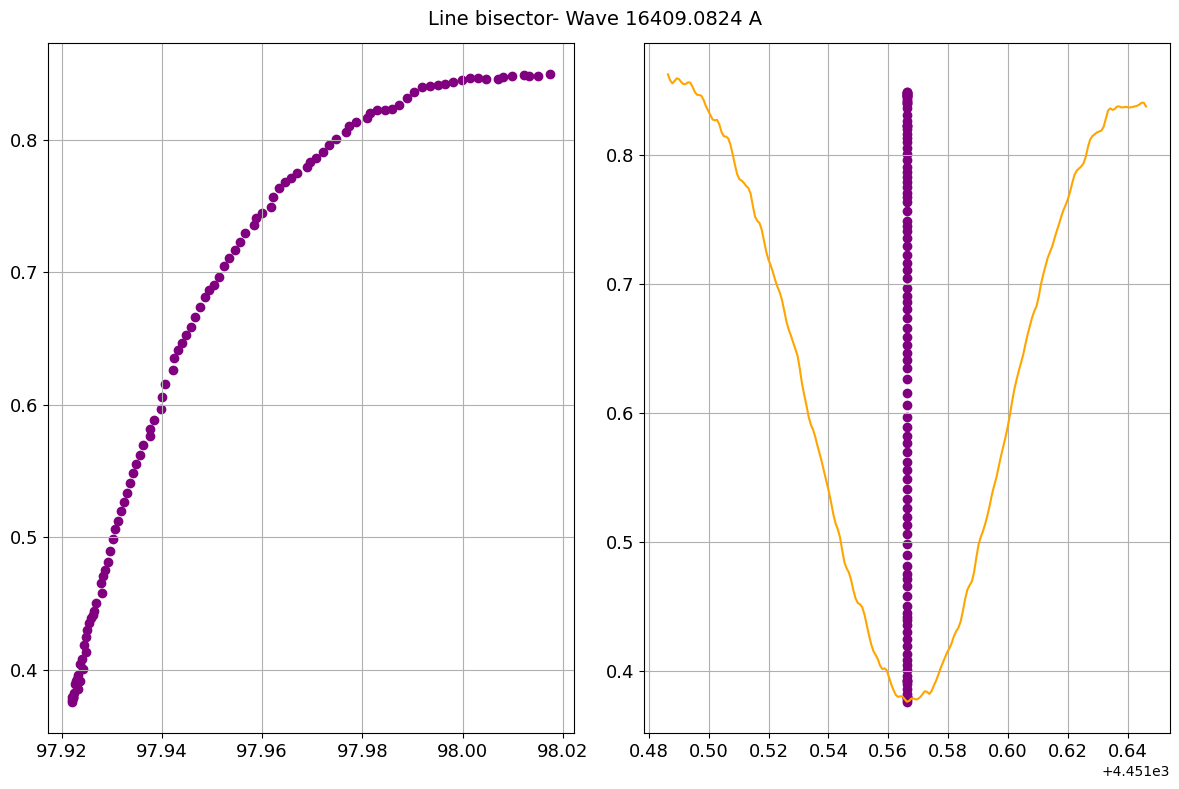

In [59]:
j = 63
fig6, axis1 = plt.subplots(1,2, figsize = (12, 8))
ax1 = axis1[0]
ax2 = axis1[1]

fig6.suptitle(r'Line bisector- Wave 16409.0824 A',fontsize=14)

ax1.scatter(bisectors[j]['c profile'],bisectors[j]['c flux'],color= 'purple')

ax2.plot(local_points_bis[j]['Wave A'],local_points_bis[j]['nFlux'],color= 'orange')
ax2.scatter(bisectors[j]['Wave c'],bisectors[j]['c flux'],color= 'purple')


ax1.grid()
ax1.tick_params(axis='both',labelsize=13)
# ax1.set_xlim(97,99)

ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig6.tight_layout()

# fig6.savefig('Relation_coef.pdf')

(4.5, 5.0)

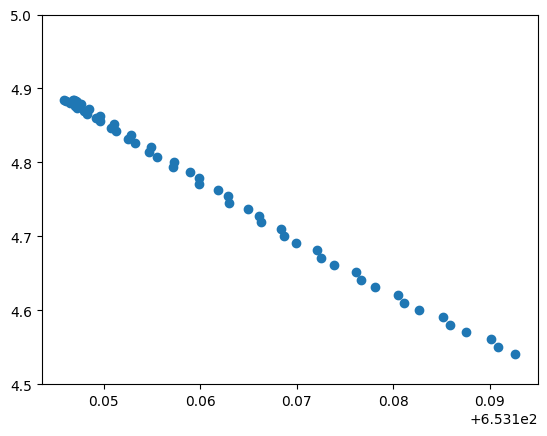

In [112]:
l = 6254.2850 #the closer to 6253
coef_gray = [2.99696652e-01, 1.03016146e-03, 6.51981616e-06, 5.13169816e-09]

dat = closer_lines[closer_lines['Fe line']  == l].index[0]
data = bisectors[dat]

standa = poly.polyval(data['c profile'],coef_gray)
planck_flux = standa-data['c flux']

plt.scatter(data['c profile'],planck_flux)
plt.ylim(4.5,5)